### Using a TRILEGAL file for a given healpix, 
### produce maps with Mr - [Fe/H] priors 

In [1]:
try:
    client.shutdown()
    client.close()

except Exception as e:
    print(e)
    pass

name 'client' is not defined


In [2]:
%matplotlib inline
import sys
sys.path.append('../src') ## why do I have to reimport all this stuff??

import healpy as hp
import hipscat
import hipscat_import
import pandas as pd
import numpy as np

import LocusTools as lt
import BayesTools as bt
import PlotTools as pt
import importlib

from dask.distributed import Client

pd.set_option('display.max_columns', None)

In [3]:
import os
import shutil
from collections import defaultdict

def delete_files_and_directories(directory):
    # Dictionary to store the count of each file extension
    extension_counts = defaultdict(int)
    file_count = 0
    dir_count = 0
    
    # Walk through the directory
    for root, dirs, files in os.walk(directory, topdown=False):
        # Delete files and collect their extensions
        for file in files:
            file_path = os.path.join(root, file)
            file_extension = os.path.splitext(file)[1]  # Get file extension
            extension_counts[file_extension] += 1
            os.remove(file_path)
            file_count += 1
        
        # Delete directories
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)
            dir_count += 1
    
    # Print the results
    print(f'Total files deleted: {file_count}')
    print(f'Total directories deleted: {dir_count}')
    print('File extensions and their counts:')
    for ext, count in extension_counts.items():
        print(f'{ext}: {count}')
    
    return file_count, dir_count, dict(extension_counts)

In [4]:
try:
    client.shutdown()
    client.close()

except Exception as e: 
    print("Exception raised", e)

    
client = Client(n_workers=96, threads_per_worker=1, memory_limit="15GiB", dashboard_address=':8787')

client

Exception raised name 'client' is not defined


/nvme/lovro/miniconda3/envs/photoD-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37029 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37029/status,
Dashboard: http://127.0.0.1:37029/status,Workers: 96
Total threads: 96,Total memory: 1.41 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42427,Workers: 96
Dashboard: http://127.0.0.1:37029/status,Total threads: 96
Started: Just now,Total memory: 1.41 TiB
Comm: tcp://127.0.0.1:42285,Total threads: 1
Dashboard: http://127.0.0.1:45929/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:44791,


## LSDB

CPU times: user 1.33 s, sys: 1.05 s, total: 2.37 s
Wall time: 5.08 s


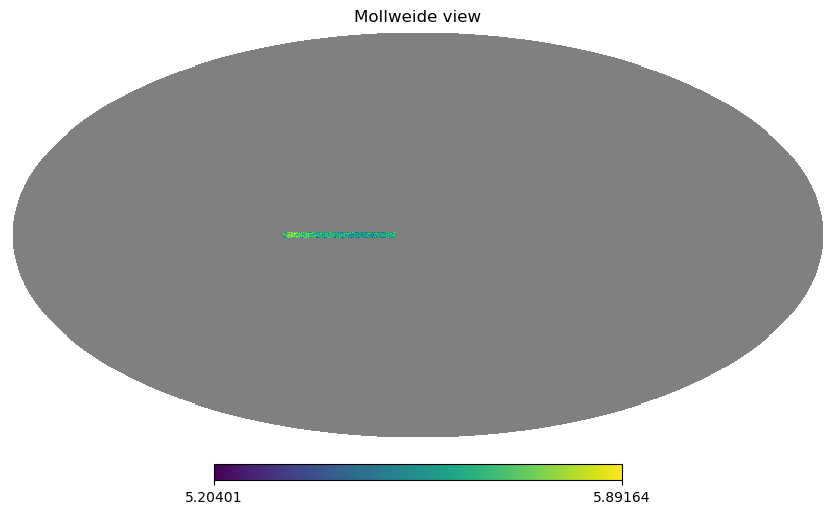

In [9]:
%%time
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
tril_fn = "/home/lovro/scratch/data/TRILEGAL_hipscat/TRILEGAL_level_5/"
tril = lsdb.read_hipscat(tril_fn, search_filter=BoxSearch(ra=(10, 60), dec=(-1., 1.))) # For testing
tril.skymap(lambda df, a: np.log(len(df)+1), order=9)

In [6]:
%%time

def prep(df, pix):
    sys.path.append('../src') ## why do I have to reimport all this stuff??
    import LocusTools as lt
    import BayesTools as bt
    import PlotTools as pt
    import importlib
    importlib.reload(lt)
    importlib.reload(bt)
    importlib.reload(pt)

    # f'http://{domain}/{lang}/{path}'
    subdir = f'{rootdir}/{str(pix.order)}'
    rootname = f'{subdir}/{str(pix.pixel)}'
    # extfile = "-%02d" % (rind) + "-%s" % (pix)     # re.findall(r'\d+', input_string)
    if not os.path.exists(subdir):
        os.makedirs(subdir)
        print(f'Directory created: {subdir}')
    else:
        print(f"Directory already exists: {subdir}")
    
    print(pix.order, pix.pixel)
    df=df.rename(columns={"gall": "glon", "galb": "glat", "gc": "comp", "m_h": "FeH", "av": "Av",
                          "mu0": "DM"})
    trilegal = lt.readTRILEGALLSDB(df)
    trilegal['Mr'] = trilegal['rmag'] - trilegal['Ar'] - trilegal['DM']
    r = bt.dumpPriorMaps_testing(trilegal, rootname, pix, verbose=False)
    # return pd.DataFrame(data=[(len(trilegal), type(trilegal))], columns=['len', 'dtype']) # <--- it is expected that a Pandas DF is returned
    return pd.DataFrame(data=[(pix, len(trilegal))], columns=['HealPix', 'len']) #, columns=['partition']) # <--- it is expected that a Pandas is returned

rootdir = '/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/results/S82_priors'  # TODO: clean this up!
# Perform the deletion and gather statistics
delete_files_and_directories(rootdir)
a = tril.map_partitions(prep, include_pixel=True).compute()

Total files deleted: 4906
Total directories deleted: 2
File extensions and their counts:
.npz: 4704
.txt: 202
Directory created: /mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/results/S82_priors/0
0 0
sample <class 'nested_pandas.nestedframe.core.NestedFrame'>
Healpix:  Order: 0, Pixel: 0 
---------------------------------------
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERROR: no data to make map (see dumpPriorMaps)
ERRO

In [7]:
a

,HealPix,len
0,"Order: 5, Pixel: 0",40172
0,"Order: 5, Pixel: 1",127
0,"Order: 5, Pixel: 2",139
0,"Order: 5, Pixel: 3072",185692
0,"Order: 5, Pixel: 3073",563
...,...,...
0,"Order: 5, Pixel: 9214",120
0,"Order: 5, Pixel: 9215",39120
0,"Order: 5, Pixel: 12285",537
0,"Order: 5, Pixel: 12286",616


CPU times: user 29 s, sys: 12.3 s, total: 41.4 s
Wall time: 1min 58s

## Run all

CPU times: user 53.1 s, sys: 34.5 s, total: 1min 27s
Wall time: 2min 6s


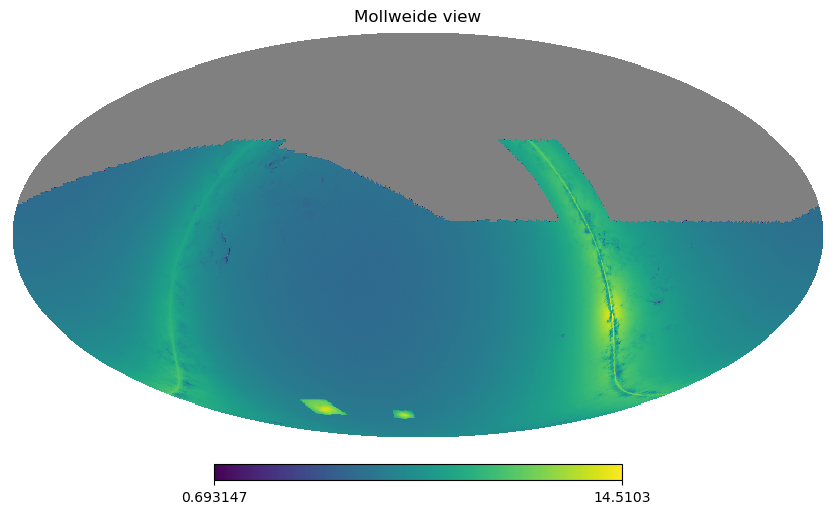

In [5]:
%%time
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch

tril_fn = "/home/lovro/scratch/data/TRILEGAL_hipscat_new_2/trilegal/"
tril = lsdb.read_hipscat(tril_fn)
tril.skymap(lambda df, a: np.log(len(df)+1), order=9)

In [ ]:
%%time
def prep(df, pix):
    sys.path.append('../src')
    import LocusTools as lt
    import BayesTools as bt
    import PlotTools as pt
    import importlib
    importlib.reload(lt)
    importlib.reload(bt)
    importlib.reload(pt)

    rootdir = '/mnt/beegfs/scratch/lovro/PhotoD/notebooks/results/MakePriorsAllSky/'  # TODO: clean this up!
    rootname = f'{rootdir}/{str(pix.order)}_{str(pix.pixel)}.csv'
    df=df.rename(columns={"gall": "glon", "galb": "glat", "gc": "comp", "m_h": "FeH", "av": "Av",
                          "mu0": "DM"})
    trilegal = lt.readTRILEGALLSDB(df)
    trilegal['Mr'] = trilegal['rmag'] - trilegal['Ar'] - trilegal['DM']
    r = bt.dumpPriorMaps_testing(trilegal, rootname, pix, verbose=True)
    # return pd.DataFrame(data=[(len(trilegal), type(trilegal))], columns=['len', 'dtype']) # <--- it is expected that a Pandas is returned
    return pd.DataFrame(data=[(pix, len(trilegal))], columns=['HealPix', 'len']) #, columns=['partition']) # <--- it is expected that a Pandas is returned

"""sys.path.append('../src')
import LocusTools as lt
import BayesTools as bt
import PlotTools as pt"""

a = tril.map_partitions(prep, include_pixel=True).compute()

# Only one healpix is returned because the outputs are overwritten!!! Fix the file naming scheme! Fix the naming scheme


CPU times: user 33min 28s, sys: 16min 14s, total: 49min 43s
Wall time: 1h 47min 21s

## File statistics

In [18]:
import os
import fnmatch

def find_files(start_dir, pattern):
    matches = []
    hp = []
    for root, dirs, files in os.walk(start_dir):
        for filename in files:
            if fnmatch.fnmatch(filename, pattern):
                matches.append(os.path.join(root, filename))
                # print("root:", root, "filename:", filename)
                _ = pd.read_csv(matches[-1], sep=r'\s+')
                s = _.Ntotal.sum()
                hp.append([root.split("/")[-1], filename.split("-")[0], s])
    return matches, hp

# Specify the directory to start the search and the pattern to match
start_directory = rootdir
file_pattern = '*SummaryStats*'

# Find files
matching_files, pixels = find_files(start_directory, file_pattern)

In [21]:
df = pd.DataFrame(data=pixels, columns=["order", "pix", "N"])
df.sort_values(["order", "pix"], inplace=True)
df.drop([4, 12], inplace=True)
df = df.astype(int)

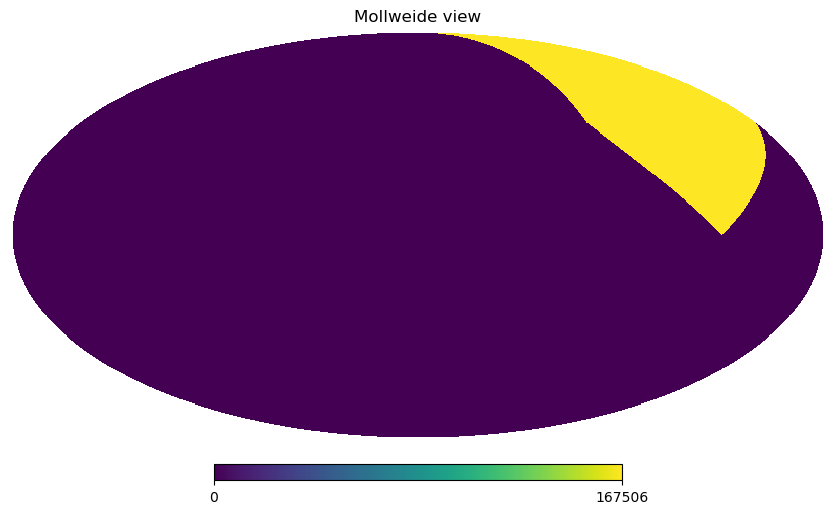

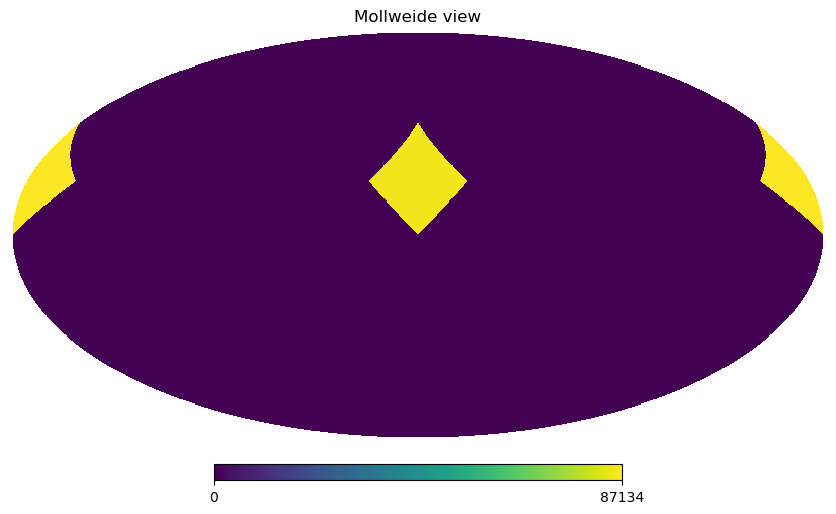

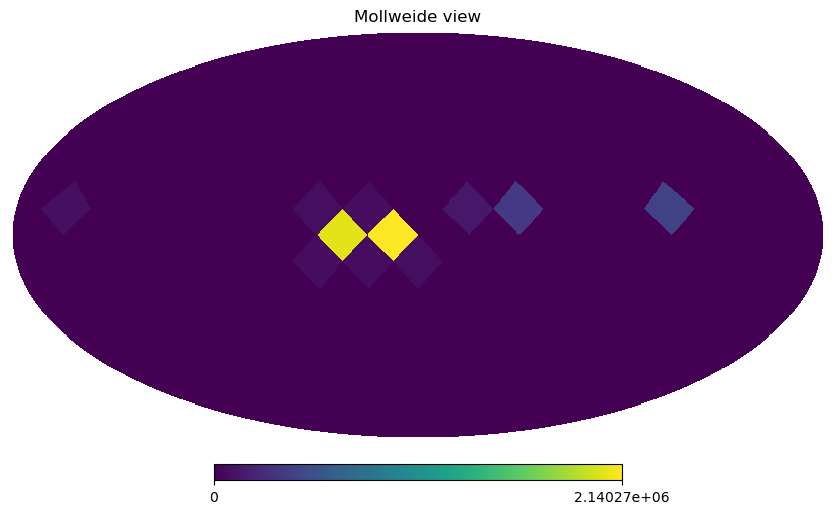

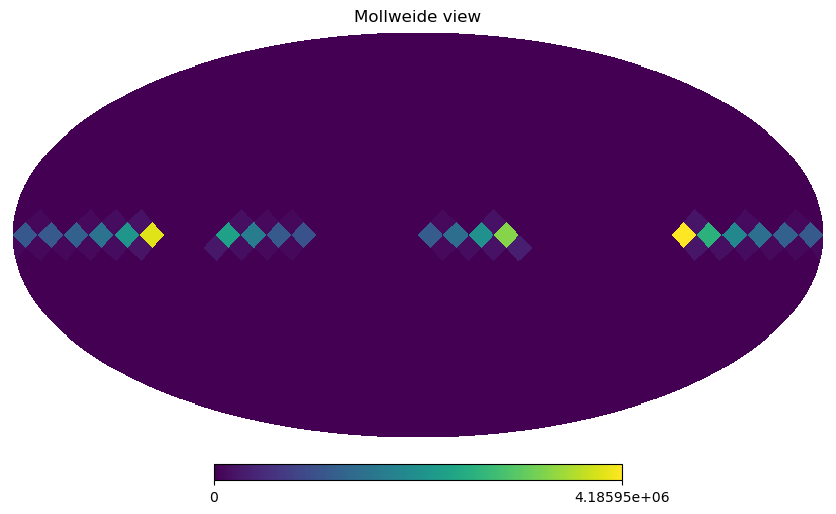

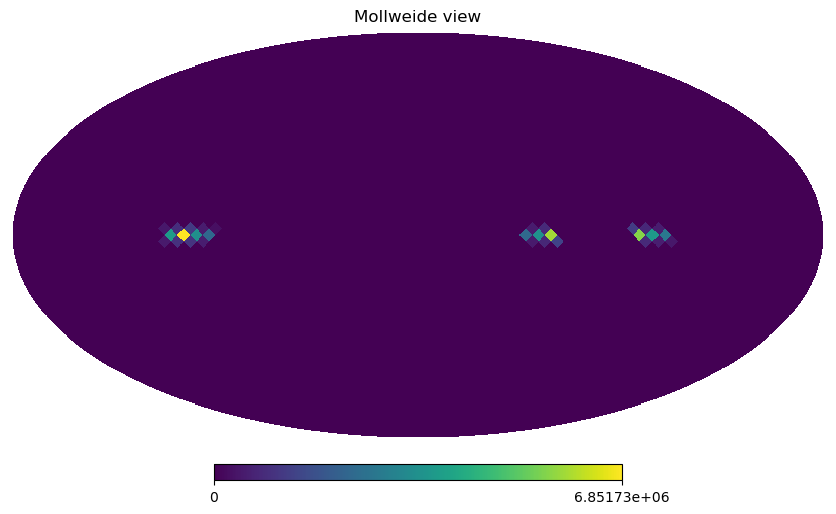

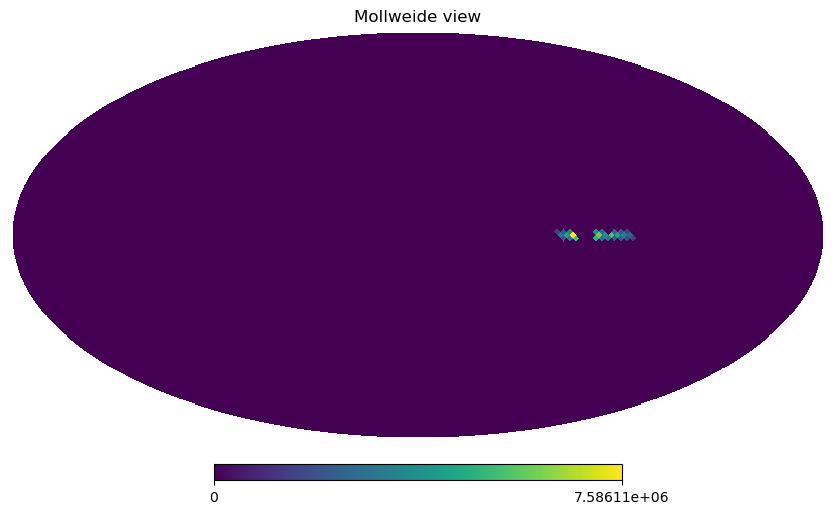

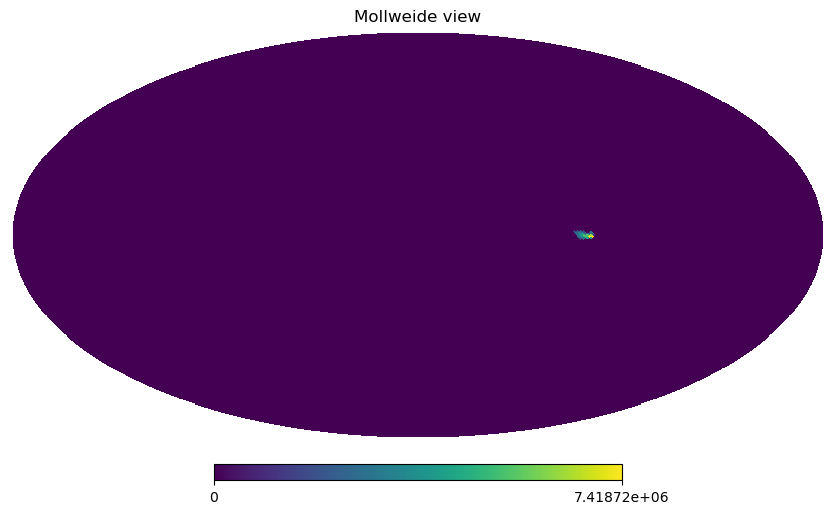

In [23]:
for o in np.unique(df.order):
    m = np.zeros(hp.order2npix(o))
    m[df.pix[df.order==o]]=df.N[df.order==o]
    hp.mollview(m, nest=True)

In [25]:
from pathlib import Path
import csv

def count_and_save_files_with_sizes(directory, output_file):
    try:
        path = Path(directory)
        file_count = 0
        with open(output_file, 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(['File Path', 'Size (MB)'])  # Write the header
            for file_path in path.glob('*'):
                if file_path.is_file():
                    size_mb = file_path.stat().st_size / (1024 * 1024)  # Convert size to MB
                    csvwriter.writerow([file_path, size_mb])  # Write the file path and size
                    file_count += 1
        return file_count
    except Exception as e:
        print(f"An error occurred: {e}")
        return 0

# Example usage
# rootdir = '/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/results/S82_priors' 
directory_path = '/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/results/S82_priors/' 
output_file_path = '/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/results/S82_priors/MakePriorsAllSky.files'
file_count = count_and_save_files_with_sizes(directory_path, output_file_path)
print(f"Number of files in '{directory_path}': {file_count}")

Number of files in '/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/results/S82_priors/': 1


In [10]:
import numpy as np
import pandas as pd

npz_file_path = '/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/results/S82_priors/5/0-00.npz'

# Load the npz file
npz_data = np.load(npz_file_path, allow_pickle=False)

# Example: Convert each array in the npz file to a DataFrame
dataframes1 = {key: pd.DataFrame(npz_data[key]) for key in npz_data.files}

npz_file_path = '/mnt/beegfs/scratch/lovro/photod-cmu/photoD/notebooks/results/S82_priors/5/0-01.npz'

# Load the npz file
npz_data = np.load(npz_file_path, allow_pickle=True)

# Example: Convert each array in the npz file to a DataFrame
dataframes2 = {key: pd.DataFrame(npz_data[key]) for key in npz_data.files}

# Access a specific DataFrame by key
# df = dataframes['your_array_name']

In [11]:
dataframes1

{'xGrid':      0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
 0  -2.5 -2.4 -2.3 -2.2 -2.1 -2.0 -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1   
 1  -2.5 -2.4 -2.3 -2.2 -2.1 -2.0 -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1   
 2  -2.5 -2.4 -2.3 -2.2 -2.1 -2.0 -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1   
 3  -2.5 -2.4 -2.3 -2.2 -2.1 -2.0 -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1   
 4  -2.5 -2.4 -2.3 -2.2 -2.1 -2.0 -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1   
 ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 91 -2.5 -2.4 -2.3 -2.2 -2.1 -2.0 -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1   
 92 -2.5 -2.4 -2.3 -2.2 -2.1 -2.0 -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1   
 93 -2.5 -2.4 -2.3 -2.2 -2.1 -2.0 -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1   
 94 -2.5 -2.4 -2.3 -2.2 -2.1 -2.0 -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1   
 95 -2.5 -2.4 -2.3 -2.2 -2.1 -2.0 -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1   
 
     

In [12]:
dataframes1['metadata'], dataframes2['metadata']

(              0
 0     -2.500000
 1      1.000000
 2     36.000000
 3     17.000000
 4     -2.000000
 5     96.000000
 6    176.041091
 7    -48.313589
 8      5.000000
 9      0.000000
 10    14.000000
 11    27.000000
 12    27.000000
 13     0.500000
 14  2163.000000
 15    14.000000,
               0
 0     -2.500000
 1      1.000000
 2     36.000000
 3     17.000000
 4     -2.000000
 5     96.000000
 6    176.041091
 7    -48.313589
 8      5.000000
 9      0.000000
 10    14.000000
 11    27.000000
 12    27.000000
 13     0.500000
 14  2646.000000
 15    14.500000)

In [196]:
20795124/19

1094480.2105263157

In [190]:
96*36

3456

In [59]:
c = ("Min    rMax   Ntotal     Amin   Amed    Amax     pMS      ppMS     pAGB      pWD        pA1       pA2      pA3      pA4       ptnD     ptkD       pH        pB        pMC").split()

In [64]:
a = pd.read_csv('/mnt/beegfs/scratch/lovro/PhotoD/notebooks/results/MakePriorsTesting/2/139-SummaryStats.txt', 
                sep=r'\s+') #, names=c)

In [68]:
a.Ntotal.cumsum(), a.Ntotal.sum()

(0        9081
 1       20656
 2       35123
 3       52745
 4       74217
 5      100213
 6      131645
 7      169872
 8      217033
 9      275493
 10     348784
 11     441591
 12     558216
 13     704264
 14     885794
 15    1109218
 16    1380180
 17    1703934
 18    2088549
 19    2540285
 20    3065734
 21    3670661
 22    4358787
 23    5130617
 24    5982654
 25    6908657
 26    7898901
 Name: Ntotal, dtype: int64,
 7898901)

In [74]:
a.to_numpy().size

513

In [184]:
513*27

13851

In [192]:
27*19

513

## Scratch space

In [11]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import os
import numpy as np

cluster = SLURMCluster(
    cores=1,
    processes=1,
    memory="10GB",
    # n_workers=300,
    shebang='#!/usr/bin/env bash',
    queue="irb_slurm",
    walltime="00:30:00",
    log_directory="/mnt/beegfs/scratch/slurm_log/",
    scheduler_options={'port': 6818, 'host':'192.168.200.100'}, 
    # local_directory='/mnt/beegfs/scratch/tmp',
    death_timeout="15s",
    # interface="bond0",
    # log_directory=f'{os.environ["SCRATCH_cecam"]}/{os.environ["USER"]}/dask_jobqueue_logs/',
    # project="ecam"
)

ModuleNotFoundError: No module named 'dask_jobqueue'

In [77]:
np.unique(a, return_counts=True)

(array([ 112567,  210022,  696958,  776826,  881369,  981651, 1025168,
        1124530, 1124700, 1128361, 1156332, 1188914, 1225620, 1235248,
        1243232, 1274153, 1291534, 1304386, 1306199, 1308926, 1320731,
        1321482, 1322556, 1354994, 1363229, 1364280, 1369538, 1392237,
        1394393, 1398447, 1411293, 1415253, 1426034, 1426293, 1430631,
        1432275, 1439474, 1439766, 1451263, 1458690, 1461692, 1461877,
        1462039, 1485536, 1500820, 1526270, 1539761, 1540429, 1545774,
        1553521, 1574848, 1591254, 1597852, 1602623, 1608167, 1650935,
        1674982, 1678839, 1686230, 1697624, 1708304, 1721011, 1727258,
        1735063, 1736854, 1736929, 1786864, 1787314, 1790450, 1792276,
        1809054, 1819400, 1823405, 1826704, 1842392, 1853778, 1867267,
        1902173, 1903009, 1964546, 1964824, 1972536, 1977620, 1978571,
        1998702, 2005900, 2031561, 2057000, 2077249, 2094489, 2105637,
        2118274, 2133615, 2173366, 2200468, 2206254, 2242670, 2247902,
      

In [26]:
import pandas as pd
import numpy as np

# Creating random data
data = {
    'A': np.random.rand(10),
    'B': np.random.randint(0, 100, 10),
    'C': np.random.choice(['X', 'Y', 'Z'], 10)
}

# Creating DataFrame
df = pd.DataFrame(data)

print(df)

          A   B  C
0  0.342904  47  X
1  0.239746  36  Y
2  0.789822  64  Z
3  0.268605  87  Y
4  0.778181  29  Y
5  0.106068   3  X
6  0.851149  34  X
7  0.723695  43  Y
8  0.706385  14  X
9  0.184090  46  X


In [30]:
filts = (df["A"]>0.5) & (df["B"]<50)
filts

0    False
1    False
2    False
3    False
4     True
5    False
6     True
7     True
8     True
9    False
dtype: bool

In [34]:
%%timeit
df[filts]

50.9 µs ± 3.39 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [35]:
%%timeit
df.iloc[filts.index]

50.3 µs ± 1.62 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
